#### code to plot the fluxes vs SST and height
#### author CLaudia Acquistapace
#### goal: plot fluxes SHF and LHF
#### date: 10/12/2021
#### edited: A. N. Meroni, 02 Feb 2022: added the uncertainty in the figure


In [2]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
#import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
#import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [3]:
data = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_binned_sst_4.nc')
#data = xr.open_dataset('/home/agostino/SST-impact_data/arthus_binned_sst_3.nc')
LHF = data.LHF.values
SHF = data.SHF.values
sst = data.sst.values
height = data.height.values

In [10]:
# define new sst array for reducing the resolution of the sampling
def f_calc_new_sst(sst_arr):
    
    #print(sst_arr)
    new_sst_arr = np.zeros(int(len(sst_arr)/2)+1)
    ind_new = 0
    for ind_sst in range(len(sst_arr)):
        if (ind_sst % 2) == 0:
            print(ind_sst)
            print(sst_arr[ind_sst])
            new_sst_arr[ind_new] = sst_arr[ind_sst]
            ind_new = ind_new+1
    #print(new_sst_arr)
    return(new_sst_arr)
new_sst_arr =  f_calc_new_sst(sst)
print(data)

0
26.283
2
26.333
4
26.382999999999996
6
26.432999999999993
8
26.48299999999999
10
26.532999999999987
12
26.582999999999984
14
26.63299999999998
16
26.68299999999998
18
26.732999999999976
20
26.782999999999973
22
26.83299999999997
24
26.882999999999967
26
26.932999999999964
28
26.98299999999996
30
27.03299999999996
32
27.082999999999956
34
27.132999999999953
36
27.18299999999995
38
27.232999999999947
40
27.282999999999944
42
27.33299999999994
44
27.38299999999994
46
27.432999999999936
48
27.482999999999933
50
27.53299999999993
52
27.582999999999927
54
27.632999999999925
<xarray.Dataset>
Dimensions:      (height: 57, sst: 55)
Coordinates:
  * sst          (sst) float64 26.28 26.31 26.33 26.36 ... 27.58 27.61 27.63
  * height       (height) float64 225.0 275.0 325.0 ... 2.975e+03 3.025e+03
Data variables:
    T            (sst, height) float64 ...
    T_std        (sst, height) float64 ...
    T_n          (sst, height) int64 ...
    MR           (sst, height) float64 ...
    MR_std     

In [11]:
# rebinning on the same bin size of the rs
def f_rebin_vars_new_sst_bins(dataset, varname, sst_bins_new):
    '''
    function to resample the data on a new set of sst bins
    input:
    - dataset: xarray dataset with specific variable
    - varname: string with variable name to be processed
    - sst_bins_new: numpy array of sst bins over which to resample
    '''
    
    # defining the new variable to create for rebinning on the new sst bins
    dims = ['sst']
    coords = {'sst':sst_bins_new}
    var_new_bins = np.zeros((len(sst_bins_new)-1, len(dataset.height.values)))
    var_new_bins.fill(np.nan)
    sst_mean_in_the_bin =  np.zeros((len(sst_bins_new)-1))
    n_in_the_bins= np.zeros((len(sst_bins_new)-1, len(dataset.height.values)))
    n_in_the_bins.fill(np.nan)
    # grouping data with respect to the rs sst bins
    for ind_arr_rs in range(len(sst_bins_new)-1):
        print(ind_arr_rs, len(sst_bins_new)-1)
        # selecting bins in the interval
        sst_inf = sst_bins_new[ind_arr_rs]
        sst_sup = sst_bins_new[ind_arr_rs+1]
        sst_mean_in_the_bin[ind_arr_rs] = (sst_inf+sst_sup)/2.
        print(' reading the sst in the interval', sst_inf, sst_sup)
        arthus_sel = dataset.sel(sst=slice(sst_inf, sst_sup))

        # calculating a weighted variable with the number of counts per bin
        weighted_var = arthus_sel[varname].values*arthus_sel[varname+'_n'].values  # Weight the selected variable with the number of values in each pixel.
        
        # adding the weighted var to the dataset
        arthus_sel['weighted_var'] = xr.DataArray(dims=['sst', 'height'], coords={'sst':arthus_sel.sst.values, 'height':arthus_sel.height.values}, data=weighted_var)
        
        # summing data in each bin
        data_sum = arthus_sel.sum(dim='sst', skipna=True)
        
        # reading the new summed values and the new weights
        sum_weighted_var = data_sum.weighted_var.values
        weight = data_sum[varname+'_n'].values           # Compute the weight of the
        var_new_bins[ind_arr_rs,:] = sum_weighted_var/weight
        n_in_the_bins[ind_arr_rs,:] = weight
        # summing the values in the new bins selected
        #sum_var_bins_dataset = arthus_sel.sum(dim='sst', skipna=True)

        # calculate new var value on the new bin 
        #var_new_bins[ind_arr_rs,:] = sum_var_bins_dataset[varname].values[:]/sum_var_bins_dataset[varname+'_n'].values[:]

    # storing the new bin dataset in xarray and returning it
    var_new_bins_da = xr.DataArray(dims=['sst_mean', 'height'], coords={'sst_mean':sst_mean_in_the_bin, 'height':dataset.height.values}, data=var_new_bins,
                     attrs={'long_name':'sst divided by the number of values '})
    weight_da = xr.DataArray(dims=['sst_mean', 'height'], coords={'sst_mean':sst_mean_in_the_bin, 'height':dataset.height.values}, data=n_in_the_bins,
                     attrs={'long_name':'number of values in the bin'})
    variables = {varname:var_new_bins_da,
                varname+'_n': weight_da}
    var_dataset_new = xr.Dataset(data_vars = variables,
                                  coords = coords)

    return(var_dataset_new)
#sst_bins_new = np.asarray([26.2, 26.6, 26.8, 27.1, 27.3, 27.66])   # sst bins array of RS
sst_bins_new = np.asarray([26.4363, 27.4587])                   # SST 10th and 90th percentile
LHF_new_data = f_rebin_vars_new_sst_bins(data, 'LHF', sst_bins_new)
SHF_new_data = f_rebin_vars_new_sst_bins(data, 'SHF', sst_bins_new)


def f_calc_profile_percentiles(data, perc_low, perc_sup):
    
    
    # selecting data below lowest percentile
    arthus_low = data.sel(sst=slice(np.nanmin(data.sst.values), perc_low))
    
    # selecting data above the highest percentile
    arthus_sup = data.sel(sst=slice(perc_sup, np.nanmax(data.sst.values)))
    
    mean_low = arthus_low.mean(dim='sst', skipna=True)
    mean_sup = arthus_sup.mean(dim='sst', skipna=True)
    std_low = arthus_low.std(dim='sst', skipna=True)
    std_sup = arthus_low.std(dim='sst', skipna=True)
    
    return(mean_low, std_low, mean_sup, std_sup)

mean_low, std_low, mean_sup, std_sup = f_calc_profile_percentiles(data, sst_bins_new[0], sst_bins_new[1])

0 1
 reading the sst in the interval 26.4363 27.4587
0 1
 reading the sst in the interval 26.4363 27.4587


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_1369/1224717396.py:41: RuntimeWarning: invalid value encountered in true_divide
  var_new_bins[ind_arr_rs,:] = sum_weighted_var/weight
/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_1369/1224717396.py:41: RuntimeWarning: invalid value encountered in true_divide
  var_new_bins[ind_arr_rs,:] = sum_weighted_var/weight


In [12]:
mean_low

<xarray.Dataset>
Dimensions:      (height: 57)
Coordinates:
  * height       (height) float64 225.0 275.0 325.0 ... 2.975e+03 3.025e+03
Data variables:
    T            (height) float64 -0.7603 -0.7603 -0.2387 ... 2.254 nan nan
    T_std        (height) float64 0.53 0.5024 0.4753 0.5383 ... 5.776 nan nan
    T_n          (height) float64 255.9 255.7 255.1 253.1 ... 1.143 0.0 0.0
    MR           (height) float64 -0.3581 -0.4003 -0.3921 ... -5.065 nan nan
    MR_std       (height) float64 0.3404 0.3422 0.3712 0.4287 ... 0.7412 nan nan
    MR_n         (height) float64 255.9 255.7 255.1 253.1 ... 1.714 0.0 0.0
    VW           (height) float64 0.1602 0.1606 0.1535 0.147 ... 2.47 nan nan
    VW_std       (height) float64 0.2016 0.2084 0.2004 0.1871 ... 0.7536 nan nan
    VW_n         (height) float64 109.0 109.0 109.0 109.0 ... 1.571 0.0 0.0
    LHF          (height) float64 -36.37 -31.79 -26.47 -16.55 ... nan nan nan
    LHF_std      (height) float64 14.23 13.86 10.23 20.6 ... nan nan nan nan
    LHF_n        (height) float64 126.4 126.4 126.4 126.4 ... 0.0 0.0 0.0 0.0
    SHF          (height) float64 -18.16 -17.45 2.084 -5.547 ... nan nan nan nan
    SHF_std      (height) float64 7.057 13.19 7.234 6.717 ... nan nan nan nan
    SHF_n        (height) float64 126.4 126.4 126.4 126.4 ... 0.0 0.0 0.0 0.0
    theta        (height) float64 -0.8656 -0.8764 -0.3533 ... -2.184 nan nan
    theta_std    (height) float64 0.5343 0.5102 0.4818 0.5461 ... 8.338 nan nan
    theta_n      (height) float64 255.9 247.3 247.3 247.3 ... 10.0 3.0 0.0 0.0
    theta_e      (height) float64 -2.066 -2.186 -1.577 -1.425 ... -6.218 nan nan
    theta_e_std  (height) float64 1.177 1.128 1.18 1.401 ... 6.792 3.741 nan nan
    theta_e_n    (height) float64 255.9 247.3 247.3 247.3 ... 1.571 0.0 0.0

['SST=26.4363', 'SST=27.4587']


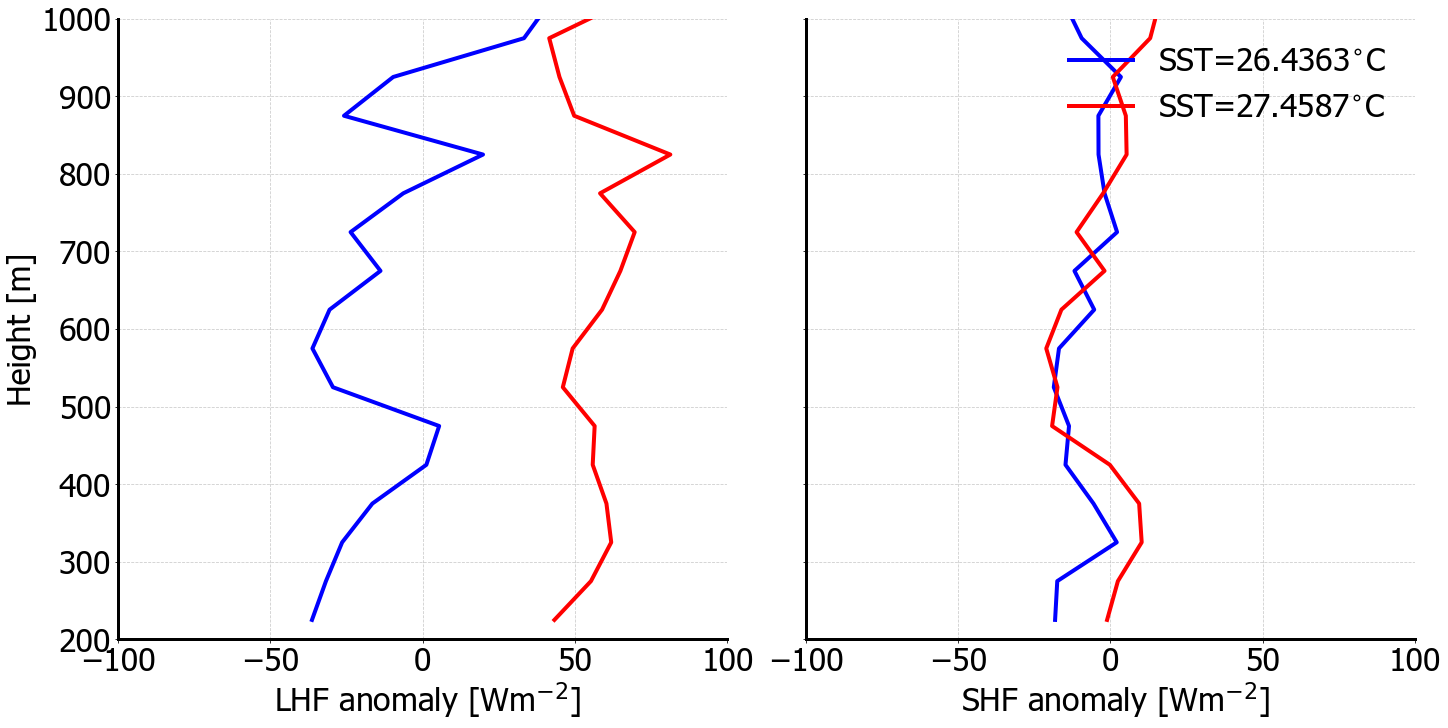

In [17]:

path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
import matplotlib.font_manager as font_manager

dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, constrained_layout=True)# 

colors_binned_sst = ['blue', 'red']
labels =[]
for ind, el in enumerate(sst_bins_new):
    labels.append('SST='+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)


#ax = fig.add_subplot(gs[0, 0])

axs[0].plot(mean_low.LHF.values, mean_low.height.values, color=colors_binned_sst[0], label=labels[0]+'$^{\circ}$C', linewidth=4, rasterized=True)
axs[0].plot(mean_sup.LHF.values, mean_low.height.values, color=colors_binned_sst[-1], label=labels[-1]+'$^{\circ}$C', linewidth=4, rasterized=True)

#axs[0].legend(frameon=False, fontsize=fontSizeX, loc='upper left')
axs[0].set_xlabel(" LHF anomaly [Wm$^{-2}$]", fontsize=fontSizeX)
axs[0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0].set_xlim(-100.,100.)
axs[0].set_ylim(200.,1000.)
axs[0].grid(linestyle='--', color='grey', alpha=0.4)

axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(3)
axs[0].spines["left"].set_linewidth(3)

axs[1].plot(mean_low.SHF.values, mean_low.height.values, color=colors_binned_sst[0], label=labels[0]+'$^{\circ}$C', linewidth=4, rasterized=True)
axs[1].plot(mean_sup.SHF.values, mean_sup.height.values, color=colors_binned_sst[-1], label=labels[-1]+'$^{\circ}$C', linewidth=4, rasterized=True)

#axs[1].plot(SHF_new_data.SHF.values[0,:], SHF_new_data.height.values, color=colors_binned_sst[0], label=labels[0]+'$^{\circ}$C', linewidth=4, rasterized=True)
#axs[1].plot(SHF_new_data.SHF.values[-1,:], SHF_new_data.height.values, color=colors_binned_sst[-1], label=labels[-1]+'$^{\circ}$C', linewidth=4, rasterized=True)
axs[1].grid(linestyle='--', color='grey', alpha=0.4)
axs[1].legend(frameon=False, fontsize=fontSizeX, loc='upper right')
axs[1].set_xlabel(" SHF anomaly [Wm$^{-2}$]", fontsize=fontSizeX)
#axs[1].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[1].set_xlim(-100.,100.)
axs[1].set_ylim(200.,1000.)

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(3)
axs[1].spines["left"].set_linewidth(3)


#axs.set_title('a) RS', fontsize=32, fontweight='black')
fig.savefig(path_out_plots+'LHF_SHF_over_sst_percentiles_R1.png')

In [9]:
# calculate MLQ for each profile averaged over SST bins
np.shape(SHF_new_data.SHF.values)

(1, 57)

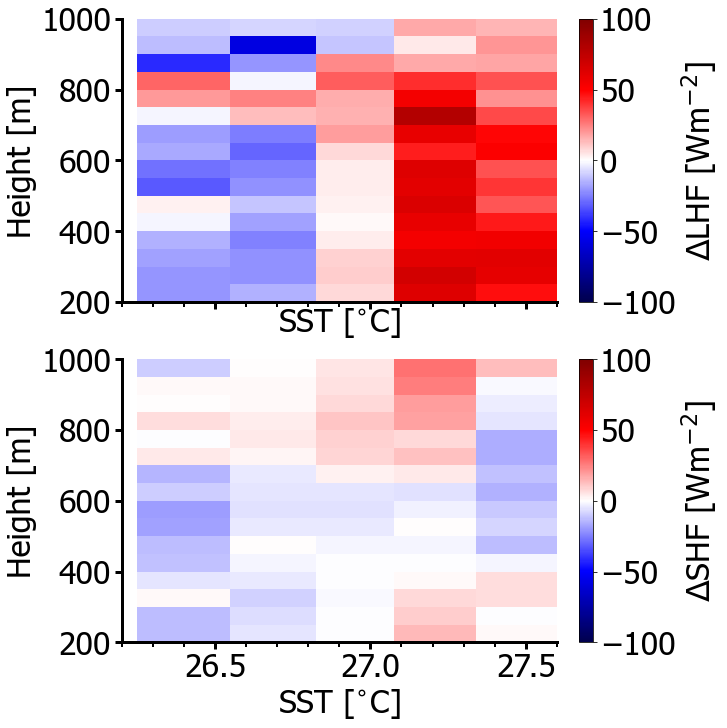

In [20]:
# plotting the masked functions
dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
#path_out_plots = '/home/agostino/SST-impact_data/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True, constrained_layout=True)
mesh1 = ax[0].pcolormesh(LHF_new_data.sst_mean.values, LHF_new_data.height.values, LHF_new_data.LHF_new_bins.values.T, cmap='seismic', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh1, ax=ax[0])
cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)
ax[0].set_ylim(200., 1000.)
ax[0].set_xlim(26.2, 27.6)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["bottom"].set_linewidth(3)
ax[0].spines["left"].set_linewidth(3)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax[0].tick_params(which='minor', length=5, width=2)
ax[0].tick_params(which='major', length=7, width=3)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax[0].tick_params(axis='both', labelsize=32)
ax[0].set_ylabel('Height [m]', fontsize=fontSizeX)

mesh2 = ax[1].pcolormesh(SHF_new_data.sst_mean.values, SHF_new_data.height.values, SHF_new_data.SHF_new_bins.values.T, cmap='seismic', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh2, ax=ax[1])
cbar.set_label(label='$\Delta$SHF [Wm$^{-2}$]',  size=fontSizeX)
ax[1].set_ylim(200., 1000.)
ax[1].set_xlim(26.2, 27.6)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["bottom"].set_linewidth(3)
ax[1].spines["left"].set_linewidth(3)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax[1].tick_params(which='minor', length=5, width=2)
ax[1].tick_params(which='major', length=7, width=3)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax[1].tick_params(axis='both', labelsize=32)
ax[1].set_ylabel('Height [m]', fontsize=fontSizeX)
ax[1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

fig.savefig(path_out_plots+'resampling_LHF_SHF_R1.png')

In [12]:
# definition of a function to calculate the uncertainty propagation


def f_uncertainty_prop(data, sigma_o, n_days, n_sigma, varstring):
    
    ''' function to propagate the uncertainty in the measurement and calculate the non-significative bins)
    inputs:
    - data: xarray dataset of data to be plotted
    - sigma_o: initial uncertainty in the data to be provided 
    - n_days: number of days used for the computation of the diurnal cycle
    - n_sigma: number of sigma chosen to check whether the measurement is different than zero.
    - varstring: string identifying the variable name
    outputs: 
    - result : xarray with values smaller than n_sigma*sigma_shf_final masked ''' 
    
    # calculation of the uncertainty propagation
    da_sigma_final = sigma_o*np.sqrt(1+1/n_days)/np.sqrt(data[varstring+'_n'])
    sigma_final = da_sigma_final.values

    # masking the dataset
    data_m = np.ma.masked_where(np.abs(data[varstring].values)>n_sigma*sigma_final,data[varstring].values)
    
    return(data_m)


#testing the function
masked_LHF = f_uncertainty_prop(LHF_new_data, 50, 8, 3, 'LHF')
masked_SHF = f_uncertainty_prop(SHF_new_data, 50, 8, 3, 'SHF')

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


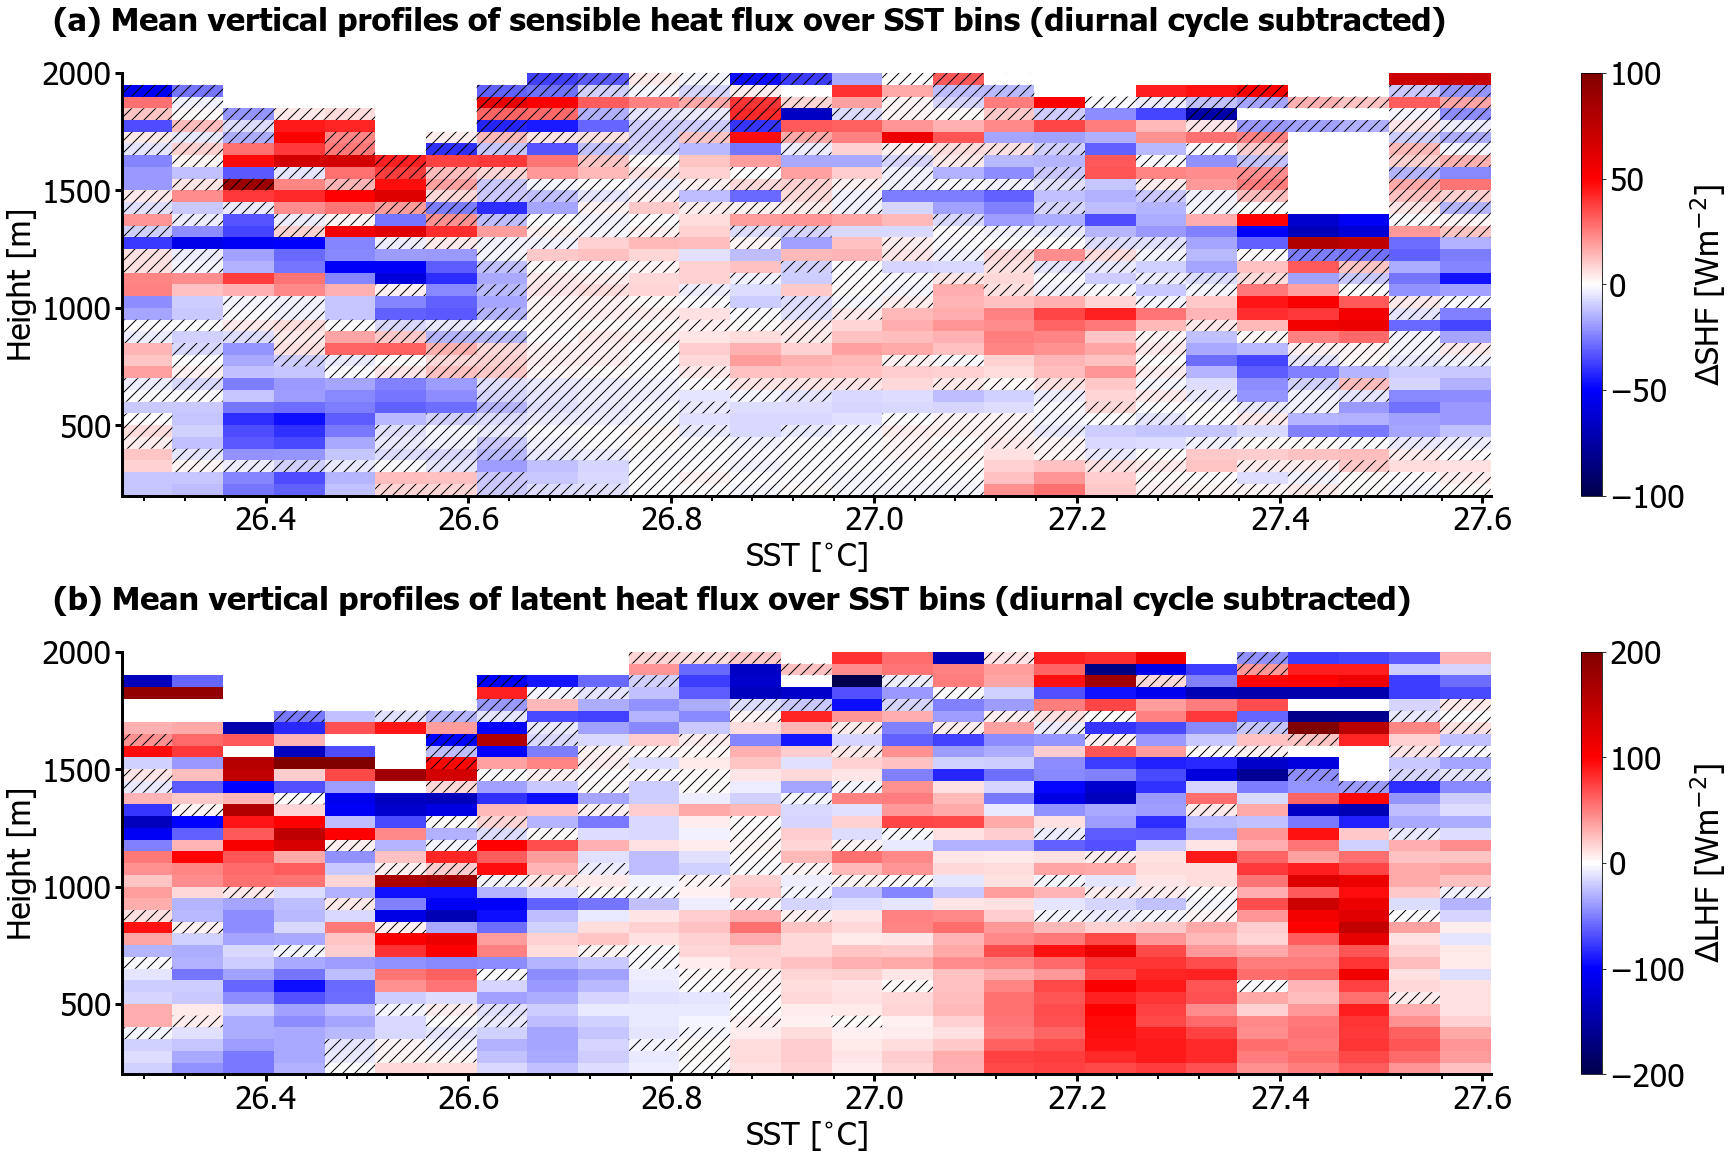

In [20]:
# plotting the masked functions
dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
#path_out_plots = '/home/agostino/SST-impact_data/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

fig, axs = plt.subplots(2,1, figsize=(24,16), constrained_layout=True)
mesh1 = axs[0].pcolormesh(new_sst_arr[:-1], height, SHF_new_data.SHF.values.T, cmap='seismic', vmin=-100., vmax=100.)
axs[0].pcolor(new_sst_arr[:-1], height, masked_SHF.T, hatch='//', alpha=0.)
cbar = fig.colorbar(mesh1, ax=axs[0])
cbar.set_label(label='$\Delta$SHF [Wm$^{-2}$]',  size=fontSizeX)

mesh2 = axs[1].pcolormesh(new_sst_arr[:-1], height, LHF_new_data.LHF.values.T, cmap='seismic', vmin=-200., vmax=200.)
axs[1].pcolor(new_sst_arr[:-1], height, masked_LHF.T, hatch='//', alpha=0.)

cbar = fig.colorbar(mesh2, ax=axs[1])
cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)
for ax, l in zip(axs[:].flatten(), ['(a) Mean vertical profiles of sensible heat flux over SST bins (diurnal cycle subtracted) ',  '(b) Mean vertical profiles of latent heat flux over SST bins (diurnal cycle subtracted) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylabel('Height [m]', fontsize=fontSizeX)
    ax.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
    ax.set_ylim(200.,2000.)
fig.savefig(path_out_plots+'figure_LHF_SHF_R1.png', format='png')

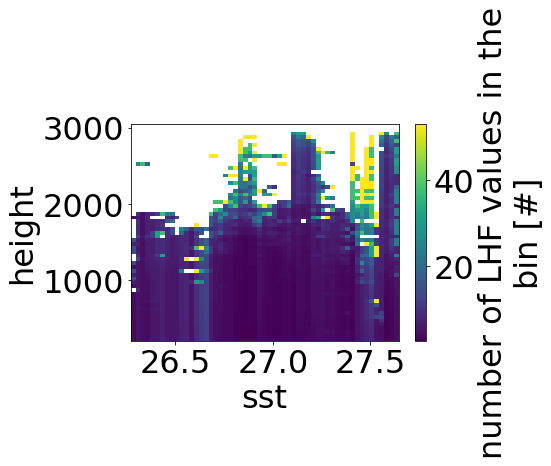

In [61]:
######## NEW ##########
# Use the number of data in each bin to propagate the uncertainty.
# Consider that, for the computation of the diurnal cycle we use 8 days (from Jan 28 to Feb 4).
ndays = 8

sigma_shf_o = 50 # Initial uncertainty -> to be set.
da_sigma_shf_final = sigma_shf_o*np.sqrt(1+1/ndays)/np.sqrt(data.SHF_n)
sigma_shf_final = da_sigma_shf_final.values

sigma_lhf_o = 50 # Initial uncertainty -> to be set.
da_sigma_lhf_final = sigma_lhf_o*np.sqrt(1+1/ndays)/np.sqrt(data.LHF_n)
da_sigma_lhf_final.plot(x='sst',y='height')
sigma_lhf_final = da_sigma_lhf_final.values

<ipython-input-62-f233754c745d>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0].pcolormesh(sst, height, SHF.T, cmap='seismic', vmin=-100., vmax=100.)
<ipython-input-62-f233754c745d>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[1].pcolormesh(sst, height, LHF.T, cmap='seismic', vmin=-200., vmax=200.)
<ipython-input-62-f233754c745d>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is dep

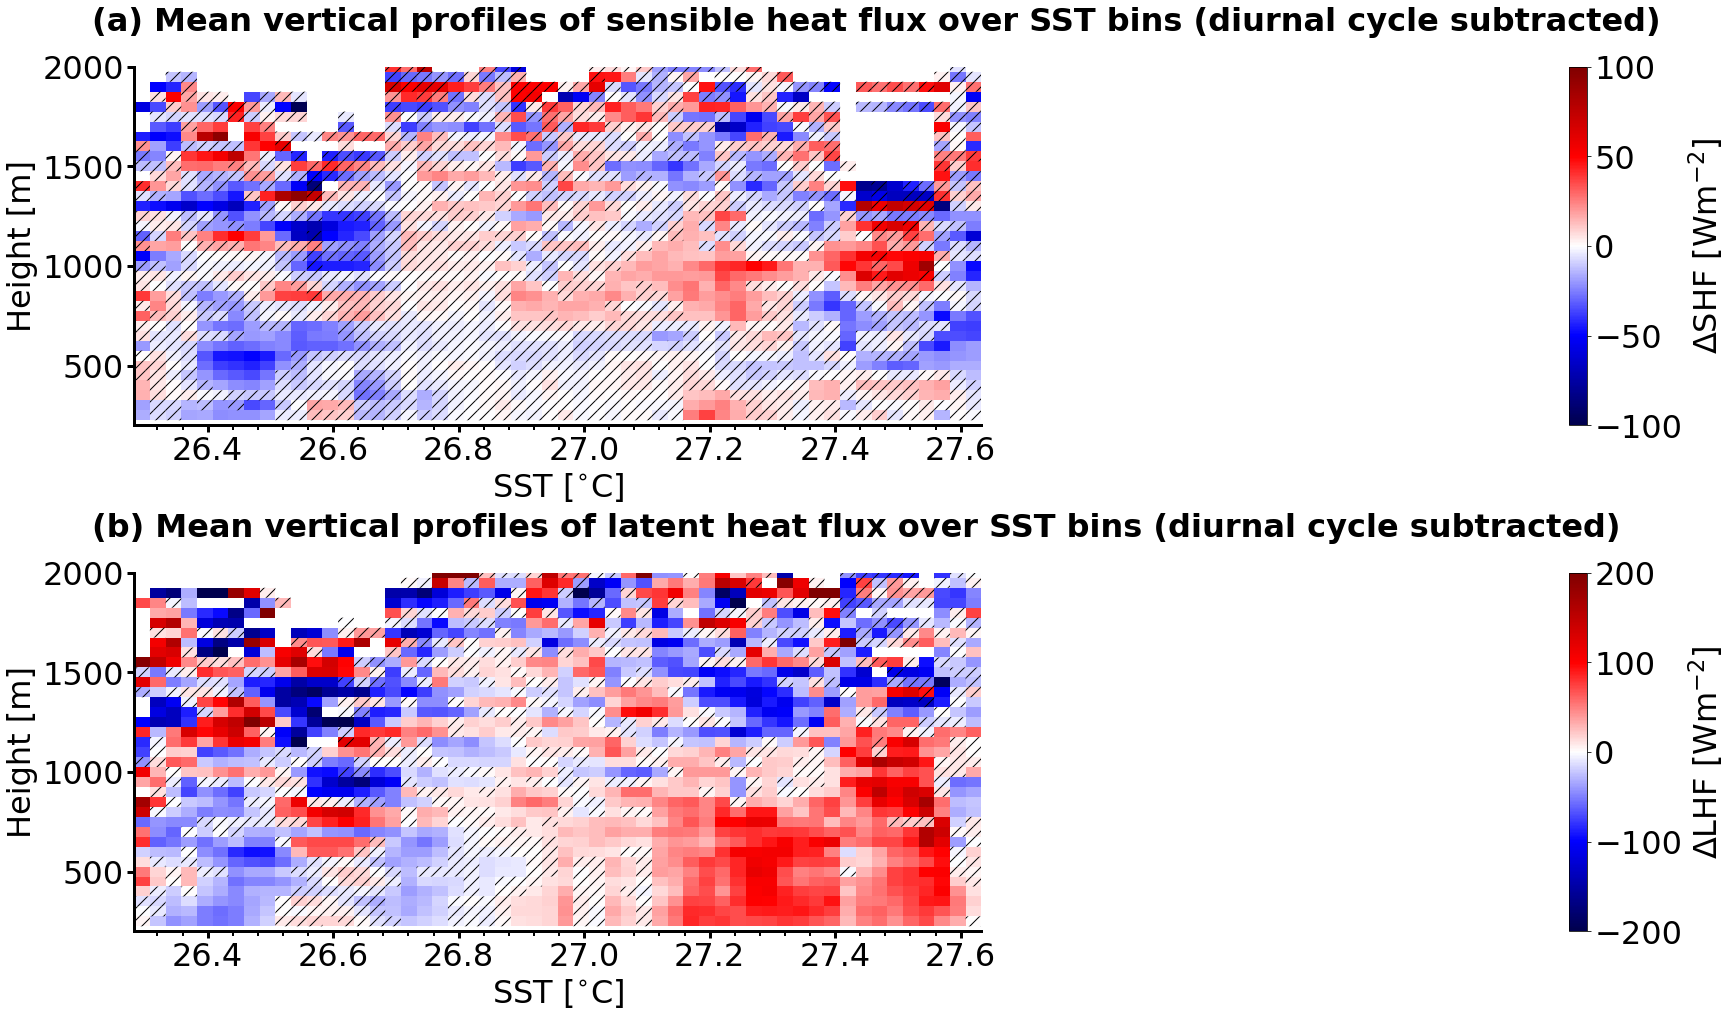

In [62]:


dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# composite figure variables binned in sst 
#path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out_plots = '/home/agostino/SST-impact_data/plots_paper/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(2,1, figsize=(24,14), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

mesh = axs[0].pcolormesh(sst, height, SHFm.T, cmap='seismic', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label(label='$\Delta$SHF [Wm$^{-2}$]',  size=fontSizeX)



mesh = axs[1].pcolormesh(sst, height, masked_LHF.T, cmap='seismic', vmin=-200., vmax=200.)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label(label='$\Delta$LHF [Wm$^{-2}$]',  size=fontSizeX)

##### NEW #####
# Use 3 sigma to check whether the measurement is different than zero.

SHFm = np.ma.masked_where(np.abs(SHF)>3*sigma_shf_final,SHF)
axs[0].pcolor(sst, height, SHFm.T, hatch='//', alpha=0.)

LHFm = np.ma.masked_where(np.abs(LHF)>3*sigma_lhf_final,LHF)
axs[1].pcolor(sst, height, LHFm.T, hatch='//', alpha=0.)

#####

for ax, l in zip(axs[:].flatten(), ['(a) Mean vertical profiles of sensible heat flux over SST bins (diurnal cycle subtracted) ',  '(b) Mean vertical profiles of latent heat flux over SST bins (diurnal cycle subtracted) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylabel('Height [m]', fontsize=fontSizeX)
    ax.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
    ax.set_ylim(200.,2000.)
fig.savefig(path_out_plots+'figure_LHF_SHF.png', format='png')

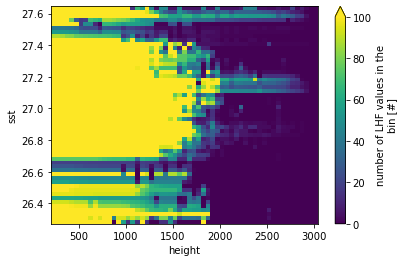

In [11]:
data.LHF_n.plot(vmin=0,vmax=100)